# K2TranPix 

In [37]:
from tqdm import tnrange, tqdm_notebook
%matplotlib notebook

In [44]:
#import matplotlib 
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import numpy as np

from scipy.ndimage.filters import convolve
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from astroquery.simbad import Simbad
from astroquery.ned import Ned
from astroquery.ned.core import RemoteServiceError
from astropy import coordinates
import astropy.units as u

from glob import glob
import os
import time as t

import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
warnings.filterwarnings("ignore",category = UserWarning)



def DriftKiller(data,thrust):
    # The right value choice here is a bit ambiguous, though it seems that typical variations are <10.
    Drift = (abs(data[thrust+1]-data[thrust-1]) < 10)*1.0 
    Drift[Drift == 0] = np.nan
    j = 0
    for i in range(len(thrust)):
        data[j:thrust[i]] = data[j:thrust[i]]*Drift[i]
        j = thrust[i]
    return data

def FindMinFrame(data,thrusters):
    # Finding the reference frame
    Framemin = data[thrusters[3]+1]
    return Framemin

def ObjectMask(datacube,Framemin):
    # Make a mask of the target object, using the reference frame 
    Mask = datacube[Framemin,:,:]/(np.nanmedian(datacube[Framemin,:,:])+np.nanstd(datacube[Framemin,:,:]))
    Mask[Mask>=1] = np.nan
    Mask[Mask<1] = 1
    # Generate a second mask from remainder of the first. This grabs the fainter pixels around known sources
    Maskv2 = datacube[Framemin,:,:]*Mask/(np.nanmedian(datacube[Framemin,:,:]*Mask)+np.nanstd(datacube[Framemin,:,:]*Mask))
    Maskv2[Maskv2>=1] = np.nan
    Maskv2[Maskv2<1] = 1
    return Maskv2

def ThrustObjectMask(data,thrust):
    StartMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        Start = data[thrust[:3]+1]*StartMask/(np.nanmedian(data[thrust[:3]+1]*StartMask, axis = (1,2))+np.nanstd(data[thrust[:3]+1]*StartMask, axis = (1,2)))[:,None,None]
        Start = Start >= 1
        temp = (np.nansum(Start*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        StartMask = StartMask*temp


    EndMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        End = data[thrust[-3:]+1]*EndMask/(np.nanmedian(data[thrust[-3:]+1]*EndMask, axis = (1,2))+np.nanstd(data[thrust[-3:]+1]*EndMask, axis = (1,2)))[:,None,None]
        End = End >= 1
        temp = (np.nansum(End*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        EndMask = EndMask*temp
    
        
    Mask = np.nansum([np.ma.masked_invalid(StartMask).mask,np.ma.masked_invalid(EndMask).mask],axis=(0))*1.0
    Mask[Mask!=2] = 1
    Mask[Mask==2] = np.nan
    return Mask



def EventSplitter(events,Times,Masks,framemask):
    Events = []
    times = []
    mask = []
    for i in range(len(events)):
        # Check if there are multiple transients
        Coincident = Masks[events[i]]*framemask[events[i]]*1
        positions = np.where(Coincident == 1)
        if len(positions[0]) > 1:
            for p in range(len(positions[0])):
                eventmask = np.zeros((Masks.shape[1],Masks.shape[2]))
                eventmask[positions[0][p],positions[1][p]] = 1
                eventmask = convolve(eventmask,np.ones((3,3)),mode='constant', cval=0.0)
                Similar = np.where((Masks[Times[i][0]:,:,:]*eventmask == eventmask).all(axis=(1,2)))[0]
                
                if len((np.diff(Similar)<5)) > 1:
                    
                    if len(np.where((np.diff(Similar)<5) == False)[0]) > 0:
                        SimEnd = np.where((np.diff(Similar)<5) == False)[0][0] 
                    else:
                        SimEnd = -1
                else:
                    SimEnd = 0

                Similar = Similar[:SimEnd]
                if len(Similar) > 1:
                    timerange = [Similar[0]+Times[i][0]-1,Similar[-1]+Times[i][0]+1]
                    if len(timerange) > 1:
                        Events.append(events[i])
                        times.append(timerange)
                        mask.append(eventmask)
                
        else:
            Events.append(events[i])
            times.append(Times[i])
            mask.append(Masks[events[i]])
            

    return Events, times, mask

def Asteroid_fitter(Mask,Time,Data, plot = False):
    lc = np.nansum(Data*Mask,axis=(1,2))
    middle = np.where(np.nanmax(lc[Time[0]-1:Time[-1]+1]) == lc)[0][0]
    if abs(Time[0] - Time[1]) < 4:
        x = np.arange(middle-1,middle+1+1,1)
    else:
        x = np.arange(middle-2,middle+2+1,1)
    if x[-1] > len(lc) - 1:
        x = x[x<len(lc)]
    x2 = np.arange(0,len(x),1)
    if np.nanmedian(lc[x]) >0:
        y = lc[x]/np.nanmedian(lc[x])
        p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)
        p2 = np.poly1d(p1)
        AvLeft = np.nansum(abs(lc[Time[0]:Time[-1]]/np.nanmedian(lc[x]) - p2(np.arange(Time[0],Time[-1]))))/(Time[-1]-Time[0])
        maxpoly = np.where(np.nanmax(p2(x)) == p2(x))[0][0]
        if (AvLeft < 2) &  (abs(middle - x[maxpoly]) < 2):
            asteroid = True
            if plot == True:
                p2 = np.poly1d(p1)
                plt.figure()
                plt.plot(x,y,'.',label='Event LC')
                plt.plot(x,p2(x),'kx',label='Parabola fit')
                plt.axvspan(Time[0],Time[1], color = 'orange',alpha=0.5, label = 'Event duration')
                plt.ylabel('Counts')
                plt.xlabel('Time')
                plt.legend()
                plt.title('Residual = ' + str(AvLeft))
                #plt.savefig('Asteroid_paper_example.pdf')
        else:
            asteroid = False
    else:
        asteroid = False

    return asteroid

def Smoothmax(interval,Lightcurve,qual):
    x = np.arange(interval[0],interval[1],1.)
    x[qual[interval[0]:interval[-1]]!=0] = np.nan 
    nbins = int(len(x)/5)
    y = np.copy(Lightcurve[interval[0]:interval[-1]])
    y[qual[interval[0]:interval[-1]]!=0] = np.nan
    
    if np.nansum(x) > 0:
        n, _ = np.histogram(x, bins=nbins,range=(np.nanmin(x),np.nanmax(x)))
        sy, _ = np.histogram(x, bins=nbins, weights=y,range=(np.nanmin(x),np.nanmax(x)))
        sy2, _ = np.histogram(x, bins=nbins, weights=y*y,range=(np.nanmin(x),np.nanmax(x)))
        mean = sy / n
        std = np.sqrt(sy2/n - mean*mean)

        xrange = np.linspace(np.nanmin(x),np.nanmax(x),len(x))
        y_smooth = np.interp(xrange, (_[1:] + _[:-1])/2, mean)
        y_smooh_error = np.interp(xrange, (_[1:] + _[:-1])/2, std)

        temp = np.copy(y)
        temp[y_smooh_error>10] =np.nan

        maxpos = np.where(temp == np.nanmax(temp))[0]+interval[0]
    else:
        maxpos = 0
    return maxpos

def ThrusterElim(Events,Times,Masks,Firings,Quality,qual,Data):
    temp = []
    temp2 = []
    temp3 = []
    asteroid = []
    asttime = []
    astmask = []
    for i in range(len(Events)):
        Range = Times[i][-1] - Times[i][0]
        if (Range > 0) & (Range/Data.shape[0] < 0.8) & (Times[i][0] > 5): 
            begining = Firings[(Firings >= Times[i][0]-2) & (Firings <= Times[i][0]+1)]
            if len(begining) == 0:
                begining = Quality[(Quality == Times[i][0])] #& (Quality <= Times[i][0]+1)]
            end = Firings[(Firings >= Times[i][-1]-1) & (Firings <= Times[i][-1]+2)]
            if len(end) == 0:
                end = Quality[(Quality == Times[i][-1])] #& (Quality <= Times[i][-1]+1)]
            eventthrust = Firings[(Firings >= Times[i][0]) & (Firings <= Times[i][-1])]

            if (~begining.any() & ~end.any()) & (len(eventthrust) < 3):
                
                if Asteroid_fitter(Masks[i],Times[i],Data):
                    asteroid.append(Events[i])
                    asttime.append(Times[i])
                    astmask.append(Masks[i])
                else:
                    LC = np.nansum(Data[Times[i][0]:Times[i][-1]+3]*Masks[i], axis = (1,2))
                    if (np.where(np.nanmax(LC) == LC)[0] < Range).all():
                    
                        temp.append(Events[i])
                        temp2.append(Times[i])
                        temp3.append(Masks[i])

            elif len(eventthrust) >= 3:

                if begining.shape[0] == 0:
                    begining = 0
                else:
                    begining = begining[0]   
                if end.shape[0] == 0:
                    end = Times[i][-1] + 10
                else:
                    end = end[0]
                LC = np.nansum(Data*Masks[i], axis = (1,2))
                maxloc = Smoothmax(Times[i],LC,qual)

                if ((maxloc > begining).all() & (maxloc < end)).all(): 
                    premean = np.nanmean(LC[eventthrust-1]) 
                    poststd = np.nanstd(LC[eventthrust+1])
                    postmean = np.nanmedian(LC[eventthrust+1])
                    Outsidethrust = Firings[(Firings < Times[i][0]) | (Firings > Times[i][-1]+20)]
                    Outsidemean = np.nanmedian(LC[Outsidethrust+1])
                    Outsidestd = np.nanstd(LC[Outsidethrust+1])
                    if  postmean > Outsidemean+2*Outsidestd:
                        temp.append(Events[i])
                        temp2.append(Times[i])
                        temp3.append(Masks[i])


    events = np.array(temp)
    eventtime = np.array(temp2)
    eventmask = np.array(temp3)
    return events, eventtime, eventmask, asteroid, asttime, astmask

def Asteroid_identifier(Events,Times,Masks,Firings,Quality,qual,Data):
    asteroid = []
    asttime = []
    astmask = []
    for i in range(len(Events)):
        Range = Times[i][-1] - Times[i][0]
        if (Range > 0) & (Range/Data.shape[0] < 0.8) & (Times[i][0] > 5): 
            begining = Firings[(Firings >= Times[i][0]-2) & (Firings <= Times[i][0]+1)]
            #if len(begining) == 0:
             #   begining = Quality[(Quality == Times[i][0])] #& (Quality <= Times[i][0]+1)]
            end = Firings[(Firings >= Times[i][-1]-1) & (Firings <= Times[i][-1]+2)]
            #if len(end) == 0:
             #   end = Quality[(Quality == Times[i][-1])] #& (Quality <= Times[i][-1]+1)]
            eventthrust = Firings[(Firings >= Times[i][0]) & (Firings <= Times[i][-1])]

            if (~begining.any() & ~end.any()) & (len(eventthrust) < 3):
                
                if Asteroid_fitter(Masks[i],Times[i],Data):
                    asteroid.append(Events[i])
                    asttime.append(Times[i])
                    astmask.append(Masks[i])
                
    return asteroid, asttime, astmask


def Match_events(Events,Eventtime,Eventmask):
    i = 0
    while i < len(Events):
        coincident = (((Eventtime[:,0] >= Eventtime[i,0]-3) & (Eventtime[:,0] <= Eventtime[i,0]+3)) | ((Eventtime[:,1] >= Eventtime[i,1]-3) & (Eventtime[:,1] <= Eventtime[i,1]+3)))       
        if sum(coincident*1) > 1:
            newmask = (np.nansum(Eventmask[coincident],axis = (0)) > 0)*1 

            Events = np.delete(Events,np.where(coincident)[0][1:])
            Eventtime = np.delete(Eventtime,np.where(coincident)[0][1:], axis = (0))
            Eventmask = np.delete(Eventmask,np.where(coincident)[0][1:], axis = (0))
            Eventmask[i] = newmask

        i +=1
        
    return Events, Eventtime,Eventmask

def Match_asteroids(Events,Eventtime,Eventmask):
    i = 0
    while i < len(Events):
        coincident = ((Eventtime[:,0] >= Eventtime[i,0]-3) & (Eventtime[:,0] <= Eventtime[i,0]+3) & (Eventtime[:,1] >= Eventtime[i,1]-3) & (Eventtime[:,1] <= Eventtime[i,1]+3))       
        if sum(coincident*1) > 1:
            newmask = (np.nansum(Eventmask[coincident],axis = (0)) > 0)*1 

            Events = np.delete(Events,np.where(coincident)[0][1:])
            Eventtime = np.delete(Eventtime,np.where(coincident)[0][1:], axis = (0))
            Eventmask = np.delete(Eventmask,np.where(coincident)[0][1:], axis = (0))
            Eventmask[i] = newmask

        i +=1
        
    return Events, Eventtime,Eventmask

def Remove_asteroids(Asteroid,Asttime,Astmask,Maskdata):
    dataclean = np.copy(Maskdata)
    for i in range(len(Asteroid)):
        dataclean[Asttime[i][0]:Asttime[i][1],Astmask[i]==1] = np.nan
    return dataclean

def First_pass(Datacube,Qual,Quality,Thrusters,Pixelfile):
    #calculate the reference frame
    Framemin = Thrusters[3]+1#FindMinFrame(Datacube)
    # Apply object mask to data
    Mask = ThrustObjectMask(Datacube,Thrusters)

    Maskdata = Datacube*Mask

    # Make a mask for the object to use as a test to eliminate very bad pointings
    obj = np.ma.masked_invalid(Mask).mask
    objmed = np.nanmedian(Datacube[Thrusters+1]*obj,axis=(0))
    objstd = np.nanstd(Datacube[Thrusters+1]*obj,axis=(0))
    Maskdata[(np.nansum(Datacube*obj,axis=(1,2)) < np.nansum(objmed-1*objstd)),:,:] = np.nan

    framemask = np.zeros(Maskdata.shape)

    limit = abs(np.nanmedian(Maskdata[Qual == 0], axis = (0))+2*(np.nanstd(Maskdata[Qual == 0], axis = (0))))
    framemask = ((Maskdata/limit) >= 1)
    framemask[:,np.where(Maskdata > 100000)[1],np.where(Maskdata > 100000)[2]] = 0

    # Identify if there is a sequence of consecutive or near consecutive frames that meet condtition 


    Eventmask_ref = (convolve(framemask,np.ones((1,3,3)),mode='constant', cval=0.0))*1
    Eventmask = np.copy(Eventmask_ref)
    Eventmask[~np.where((convolve(Eventmask_ref,np.ones((5,1,1)),mode='constant', cval=0.0) >= 3))[0]] = 0
    Eventmask[Qual!=0,:,:] = False
    Eventmask_ref[Qual!=0,:,:] = False

    Index = np.where(np.nansum(Eventmask*1, axis = (1,2))>0)[0]

    events = []
    eventtime = []
    while len(Index) > 1:

        similar = np.where(((Eventmask[Index[0]]*Eventmask_ref[Index[0]:]) == Eventmask[Index[0]]).all(axis = (1,2)))[0]+Index[0]

        if len((np.diff(similar)<5)) > 1:

            if len(np.where((np.diff(similar)<5) == False)[0]) > 0:
                simEnd = np.where((np.diff(similar)<5) == False)[0][0] 
            else:
                simEnd = -1
        else:
            simEnd = 0
        if (simEnd > 0):
            similar = similar[:simEnd]
        elif (simEnd == 0):
            similar = np.array([similar[0]])

        if len(similar) > 1:

            events.append(similar[0])
            temp = [similar[0]-1,similar[-1]+1]
            eventtime.append(temp)
            temp = []
        template = Eventmask[Index[0]]
        for number in similar:
            if (np.nansum(template*1-Eventmask[number]*1) == 0):
                Index = np.delete(Index, np.where(Index == number)[0])

    events, eventtime, eventmask = EventSplitter(events,eventtime,Eventmask,framemask)  

    events = np.array(events)
    eventmask = np.array(eventmask)
    eventtime = np.array(eventtime)

    temp = []
    for i in range(len(events)):
        if len(np.where(Datacube[eventtime[i][0]:eventtime[i][-1]]*eventmask[i] > 100000)[0]) == 0:
            temp.append(i)
    eventtime = eventtime[temp]
    events = events[temp]
    eventmask = eventmask[temp]

    if len(eventmask) > 0:
        middle = (convolve(eventmask,np.ones((1,3,3))) == np.nanmax(convolve(eventmask,np.ones((1,3,3))))) & (convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0) == np.nanmax(convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0)))
        eventmask = eventmask*middle


    # Identify asteroids
    asteroid, asttime, astmask = Asteroid_identifier(events,eventtime,eventmask,Thrusters,Quality,Qual,Maskdata)
    asteroid = np.array(asteroid)
    asttime = np.array(asttime)
    astmask = np.array(astmask)


    asteroid, asttime, astmask = Match_asteroids(asteroid,asttime,astmask)

    Cleandata = Remove_asteroids(asteroid,asttime,astmask,Maskdata)

                # Save asteroids
    ast = {}
    ast['File'] = Pixelfile
    ast['Asteroids'] = asteroid
    ast['Time'] = asttime
    ast['Mask'] = astmask

    return Cleandata, ast

def Motion_correction(Data,Mask,Thrusters):
    Corrected = np.zeros((Data.shape[0],Data.shape[1],Data.shape[2]))
    
    fit = np.zeros(len(Data))
    X = np.where(Mask == 1)[0]
    Y = np.where(Mask == 1)[1]
    for j in range(len(X)):
        temp = np.copy(Data[:,X[j],Y[j]])
        #temp[temp==0] = np.nan
        zz = np.arange(0,len(Data))
        AvSplinepoints = np.zeros(len(Thrusters))
        AvSplineind = np.zeros(len(Thrusters))
        for i in range(len(Thrusters)):
            AvSplinepoints[i] = np.nanmin(Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])
            if ~np.isnan(AvSplinepoints[i]):
                if len(np.where(AvSplinepoints[i] == Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])[0]+Thrusters[i]+1) > 1:
                    AvSplineind[i] = np.where(AvSplinepoints[i] == Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])[0][0]+Thrusters[i]+1
                else:
                    AvSplineind[i] = np.where(AvSplinepoints[i] == Data[Thrusters[i]+1:Thrusters[i]+3,X[j],Y[j]])[0]+Thrusters[i]+1 
            else:
                AvSplineind[i] = np.nan
        ind = np.where(~np.isnan(AvSplineind))
        if len(ind[0]) > 1:
            Splinef = interp1d(AvSplineind[ind],AvSplinepoints[ind], kind='linear',fill_value='extrapolate' )
            Spline = Splinef(zz)
            Spline[np.isnan(Spline)] = 0
            for i in range(len(Thrusters)-1):

                if abs(Thrusters[i]-Thrusters[i+1]) > 5:
                    try:
                        Section = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - Spline[Thrusters[i]+2:Thrusters[i+1]]
                        temp2 = np.copy(Section)
                        x = np.arange(0,len(Section))
                        limit =np.nanmedian(np.diff(np.diff(Section)))+2.5*np.nanstd(np.diff(np.diff(Section)))
                        yo = np.where(np.diff(np.diff(Section))>limit)[0]+1
                        if len(yo)/2 == int(len(yo)/2):
                            z = 0
                            while z + 1 < len(yo):
                                yoarr = np.arange(yo[z],yo[z+1])
                                temp2[yoarr] = np.nan
                                yo = np.delete(yo,[0,1])
                        else:
                            z = 0
                            while z + 2 < len(yo):
                                yoarr = np.arange(yo[z],yo[z+1])
                                temp2[yoarr] = np.nan
                                yo = np.delete(yo,[0,1])
                        if len(yo) == 1:
                            temp[yo] = np.nan
                        xx = np.where(~np.isnan(temp2))[0]
                        if len(xx) > 3:
                            p3 = np.poly1d(np.polyfit(xx, Section[xx], 3))
                            temp[x+Thrusters[i]+2] = np.copy(Data[Thrusters[i]+2:Thrusters[i+1],X[j],Y[j]]) - p3(x) #+ Spline[thrusters[i]+2:thrusters[i+1]]
                            fit[x+Thrusters[i]+2] = p3(x)
                        #else:
                         #   print(i)
                    except RuntimeError:
                        pass
        Corrected[:,X[j],Y[j]] = temp
        
                    
    return Corrected

def pix2coord(x,y,mywcs):
    wx, wy = mywcs.wcs_pix2world(x, y, 0)
    return np.array([float(wx), float(wy)])

def Get_gal_lat(mywcs,datacube):
    ra, dec = mywcs.wcs_pix2world(int(datacube.shape[1]/2), int(datacube.shape[2]/2), 0)
    b = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs').galactic.b.degree
    return b
def Identify_masks(Obj):
    # Uses an iterrative process to find spacially seperated masks in the object mask.
    objsub = np.copy(Obj)
    Objmasks = []

    mask1 = np.zeros((Obj.shape))
    mask1[np.where(objsub==1)[0][0],np.where(objsub==1)[1][0]] = 1
    while np.nansum(objsub) > 0:

        conv = ((convolve(mask1*1,np.ones((3,3)),mode='constant', cval=0.0)) > 0)*1.0
        objsub = objsub - mask1
        objsub[objsub < 0] = 0

        if np.nansum(conv*objsub) > 0:
            
            mask1 = mask1 + (conv * objsub)
            mask1 = (mask1 > 0)*1
        else:
            
            Objmasks.append(mask1)
            mask1 = np.zeros((Obj.shape))
            if np.nansum(objsub) > 0:
                mask1[np.where(objsub==1)[0][0],np.where(objsub==1)[1][0]] = 1
    return Objmasks

def Database_event_check(Data,Eventtime,Eventmask,WCS):
    # Checks Ned and Simbad to check the event position against known objects.
    Objects = []
    Objtype = []
    for I in range(len(Eventtime)):
        maxcolor = np.nanmax(Data[Eventtime[I][0]:Eventtime[I][-1]]*(Eventmask[I]==1))
            
        Mid = np.where(Data[Eventtime[I][0]:Eventtime[I][-1]]*(Eventmask[I]==1) == maxcolor)
        
        Coord = pix2coord(Mid[1],Mid[0],WCS)

        c = coordinates.SkyCoord(ra=Coord[0], dec=Coord[1],unit=(u.deg, u.deg), frame='icrs')

        Ob = 'Unknown'
        objtype = 'Unknown'
        try:
            result_table = Ned.query_region(c, radius = 6*u.arcsec, equinox='J2000')
            Ob = np.asarray(result_table['Object Name'])[0].decode("utf-8") 
            if b'*' == result_table['Type'][0]:
                objtype = 'Star'
            elif b'G' == result_table['Type'][0]:
                objtype = 'Galaxy'
            elif b'QSO' == result_table['Type'][0]:
                objtype = 'QSO'
            else:
                objtype = 'Ned'

        except RemoteServiceError:
            result_table = Simbad.query_region(c,radius = 6*u.arcsec)
            try:
                if len(result_table.colnames) > 0:
                    Ob = np.asarray(result_table['MAIN_ID'])[0].decode("utf-8") 
                    objtype = 'Simbad'
            except AttributeError:
                pass
        Objects.append(Ob)
        Objtype.append(objtype)
    #Objects = np.array(Objects)
    #Objtype = np.array(Objtype)
    return Objects, Objtype

def Database_check_mask(Datacube,Thrusters,Masks,WCS):
    # Checks Ned and Simbad to find the object name and type in the mask.
    # This uses the mask set created by Identify_masks.
    Objects = []
    Objtype = []
    av = np.nanmedian(Datacube[Thrusters+1],axis = 0)
    for I in range(len(Masks)):

        Mid = np.where(av*Masks[I] == np.nanmax(av*Masks[I]))

        Coord = pix2coord(Mid[0][0],Mid[1][0],WCS)

        c = coordinates.SkyCoord(ra=Coord[0], dec=Coord[1],unit=(u.deg, u.deg), frame='icrs')
        Ob = 'Unknown'
        objtype = 'Unknown'
        try:
            result_table = Ned.query_region(c, radius = 12*u.arcsec, equinox='J2000')
            Ob = np.asarray(result_table['Object Name'])[0].decode("utf-8") 
            if b'*' == result_table['Type'][0]:
                objtype = 'Star'
            elif b'G' == result_table['Type'][0]:
                objtype = 'Galaxy'
            elif b'QSO' == result_table['Type'][0]:
                objtype = 'QSO'
            else:
                objtype = 'Ned'

        except RemoteServiceError:
            result_table = Simbad.query_region(c,radius = 12*u.arcsec)
            try:
                if len(result_table.colnames) > 0:
                    Ob = np.asarray(result_table['MAIN_ID'])[0].decode("utf-8") 
                    objtype = 'Simbad'
            except AttributeError:
                pass
        Objects.append(Ob)
        Objtype.append(objtype)
    #Objects = np.array(Objects)
    #Objtype = np.array(Objtype)
    return Objects, Objtype

def Near_which_mask(Eventmask,Objmasks):
    # Finds which mask in the object mask an event is near. The value assigned to Near_mask 
    # is the index of Objmask that corresponds to the event. If not mask is near, value is nan.
    Near_mask = np.ones(len(Eventmask),dtype=int)*-1
    for i in range(len(Objmasks)):
        near_mask = ((convolve(Objmasks[i]*1,np.ones((3,3)),mode='constant', cval=0.0)) > 0)*1
        isnear = near_mask*Eventmask
        Near_mask[np.where(isnear==1)[0]] = int(i)
    return Near_mask




def Save_space(Save):
    try:
        if not os.path.exists(Save):
            os.makedirs(Save)
    except FileExistsError:
        pass

def K2TranPixFig(Events,Eventtime,Eventmask,Data,Time,Frames,wcs,Save,File,Quality,Thrusters,Framemin,Datacube,Source,SourceType):
    for i in range(len(Events)):
        # Check if there are multiple transients
        #Find Coords of transient
        position = np.where(Eventmask[i])
        maxcolor = np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1]]*(Eventmask[i]==1))

        Mid = np.where(Data[Eventtime[i][0]:Eventtime[i][-1]]*(Eventmask[i]==1) == maxcolor)

        Coord = pix2coord(Mid[1],Mid[0],wcs)
        # Generate a light curve from the transient masks
        LC = np.nansum(Data*Eventmask[i], axis = (1,2))
        BG = Data*~Frames[Events[i]]
        BG[BG <= 0] =np.nan
        BGLC = np.nanmedian(BG, axis = (1,2))

        Obj = np.ma.masked_invalid(Data[Framemin]).mask
        ObjLC = np.nansum(Datacube*Obj,axis = (1,2))
        ObjLC = ObjLC/np.nanmedian(ObjLC)*np.nanmedian(LC)#np.nanmax(LC)/np.nanmax(ObjLC)


        fig = plt.figure(figsize=(10,6))
        # set up subplot grid
        gridspec.GridSpec(2,3)
        plt.suptitle('Source: '+ Source[i] + ' (' + SourceType[i] + ')')
        # large subplot
        plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
        plt.title('Event light curve (BJD '+str(round(Time[Eventtime[i][0]]-Time[0],2))+', RA '+str(round(Coord[0],3))+', DEC '+str(round(Coord[1],3))+')')
        plt.xlabel('Time (+'+str(Time[0])+' BJD)')
        plt.ylabel('Counts')
        plt.plot(Time - Time[0], LC,'.', label = 'Event LC')
        plt.plot(Time - Time[0], BGLC,'k.', label = 'Background LC')
        plt.plot(Time - Time[0], ObjLC,'kx', label = 'Scaled object LC')
        if Eventtime[i][-1] < len(Time):
            plt.axvspan(Time[Eventtime[i][0]]-Time[0],Time[Eventtime[i][-1]]-Time[0], color = 'orange', label = 'Event duration')
        else:
            plt.axvspan(Time[Eventtime[i][0]]-Time[0],Time[-1]-Time[0], color = 'orange', label = 'Event duration')
        plt.axvline(Time[Quality[0]]-Time[0],color = 'red', linestyle='dashed',label = 'Quality', alpha = 0.5)
        for j in range(Quality.shape[0]-1):
            j = j+1 
            plt.axvline(Time[Quality[j]]-Time[0], linestyle='dashed', color = 'red', alpha = 0.5)
        # plot Thurster firings 
        plt.axvline(Time[Thrusters[0]]-Time[0],color = 'red',label = 'Thruster', alpha = 0.5)
        for j in range(Thrusters.shape[0]-1):
            j = j+1 
            plt.axvline(Time[Thrusters[j]]-Time[0],color = 'red', alpha = 0.5)
        xmin = Time[Eventtime[i][0]]-Time[0]-(Eventtime[i][-1]-Eventtime[i][0])/10
        xmax = Time[Eventtime[i][-1]]-Time[0]+(Eventtime[i][-1]-Eventtime[i][0])/10
        if xmin < 0:
            xmin = 0
        if xmax > Time[-1] - Time[0]:
            xmax = Time[-1] - Time[0]
        plt.xlim(xmin,xmax) # originally 48 for some reason
        plt.ylim(0,np.nanmax(LC[Eventtime[i][0]:Eventtime[i][-1]])+0.1*np.nanmax(LC[Eventtime[i][0]:Eventtime[i][-1]]))
        plt.legend(loc = 1)
        # small subplot 1 Reference image plot
        plt.subplot2grid((2,3), (0,2))
        plt.title('Reference')
        plt.imshow(Data[Framemin,:,:], origin='lower',vmin=0,vmax = maxcolor)
        current_cmap = plt.cm.get_cmap()
        current_cmap.set_bad(color='black')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.plot(position[1],position[0],'r.',ms = 15)
        # small subplot 2 Image of event
        plt.subplot2grid((2,3), (1,2))
        plt.title('Event')
        plt.imshow(Data[np.where(Data*Eventmask[i]==np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1]]*Eventmask[i]))[0][0],:,:], origin='lower',vmin=0,vmax = maxcolor)
        current_cmap = plt.cm.get_cmap()
        current_cmap.set_bad(color='black')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.plot(position[1],position[0],'r.',ms = 15)
        

        if len(Thrusters[(Thrusters >= Eventtime[i][0]) & (Thrusters <= Eventtime[i][-1])]) >= 3:
            if maxcolor <= 10:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Long/Faint/Near/' + SourceType[i].split('Near: ')[-1] + '/'
                    Save_space(directory)
                else:
                    directory = Save+'/Figures/Long/Faint/' + SourceType[i] + '/'
                    Save_space(directory)
            else:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Long/Bright/Near/' + SourceType[i].split('Near: ')[-1] + '/'
                    Save_space(directory)
                else:
                    directory = Save+'/Figures/Long/Bright/' + SourceType[i] + '/'
                    Save_space(directory)
        else:
            if maxcolor <= 10:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Short/Faint/Near/' + SourceType[i].split('Near: ')[-1] + '/'
                    Save_space(directory)
                else:
                    directory = Save+'/Figures/Short/Faint/' + SourceType[i] + '/'
                    Save_space(directory)
            else:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Short/Bright/Near/' + SourceType[i].split('Near: ')[-1] + '/'
                    Save_space(directory)
                else:
                    directory = Save+'/Figures/Short/Bright/' + SourceType[i] + '/'
                    Save_space(directory)
            

        plt.savefig(directory+File.split('/')[-1].split('-')[0]+'_'+str(i)+'.pdf', bbox_inches = 'tight')
        #plt.close();



def K2TranPixGif(Events,Eventtime,Eventmask,Data,wcs,Save,File,Source,SourceType):
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='RGRH'), bitrate=1800)
    for i in range(len(Events)):
        position = np.where(Eventmask[i])
        
        maxcolor = np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1],(Eventmask[i] == 1)])

        xmin = Eventtime[i][0]-(Eventtime[i][1]-Eventtime[i][0])
        xmax = Eventtime[i][1]+(Eventtime[i][1]-Eventtime[i][0])
        if xmin < 0:
            xmin = 0
        if xmax > len(Data):
            xmax = len(Data)-1
        Section = Data[int(xmin):int(xmax),:,:]
        fig = plt.figure()
        fig.set_size_inches(6,6)
        ims = []
        for j in range(Section.shape[0]):
            im = plt.imshow(Section[j], origin='lower',vmin = 0, vmax = maxcolor, animated=True)
            plt.plot(position[1],position[0],'r.',ms = 15)
            ims.append([im])
        plt.suptitle('Source: '+ Source[i] + ' (' + SourceType[i] + ')')
        plt.title(File.split('/')[-1].split('-')[0]+' Event # '+str(i))
        ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat = False)
        c = plt.colorbar(fraction=0.046, pad=0.04)
        c.set_label('Counts')
        
        if len(Thrusters[(Thrusters >= Eventtime[i][0]) & (Thrusters <= Eventtime[i][-1])]) >= 3:
            if maxcolor <= 10:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Long/Faint/Near/' + SourceType[i].split('Near: ')[-1] + '/'
                    Save_space(directory)
                else:
                    directory = Save+'/Figures/Long/Faint/' + SourceType[i] + '/'
                    Save_space(directory)
            else:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Long/Bright/Near/' + SourceType[i].split('Near: ')[-1] + '/'
                    Save_space(directory)
                else:
                    directory = Save+'/Figures/Long/Bright/' + SourceType[i] + '/'
                    Save_space(directory)
        else:
            if maxcolor <= 10:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Short/Faint/Near/' + SourceType[i].split('Near: ')[-1] + '/'
                    Save_space(directory)
                else:
                    directory = Save+'/Figures/Short/Faint/' + SourceType[i] + '/'
                    Save_space(directory)
            else:
                if 'Near: ' in Source[i]:
                    directory = Save+'/Figures/Short/Bright/Near/' + SourceType[i].split('Near: ')[-1] + '/'
                    Save_space(directory)
                else:
                    directory = Save+'/Figures/Short/Bright/' + SourceType[i] + '/'
                    Save_space(directory)
            
        ani.save(directory+File.split('/')[-1].split('-')[0]+'_'+str(i)+'.mp4',dpi=300)
        plt.close();




def K2TranPix(pixelfile,save): # More efficient in checking frames
    Save = save + pixelfile.split('-')[1].split('_')[0]
    try:
        hdu = fits.open(pixelfile)
        dat = hdu[1].data
        datacube = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data#np.copy(testdata)#
        if datacube.shape[1] > 1 and datacube.shape[2] > 1:
            time = dat["TIME"] + 2454833.0
            Qual = hdu[1].data.field('QUALITY')
            thrusters = np.where((Qual == 1048576) | (Qual == 1089568) | (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | (Qual == 10240) | (Qual == 32768) | (Qual == 1097760))[0]
            quality = np.where(Qual != 0)[0]
            #calculate the reference frame
            Framemin = thrusters[3]+1
            # Apply object mask to data
            Mask = ThrustObjectMask(datacube,thrusters)

            Maskdata, ast = First_pass(np.copy(datacube),Qual,quality,thrusters,pixelfile)
            Maskdata = Maskdata*Mask
            Maskdata = Motion_correction(Maskdata,Mask,thrusters)*Mask

            # Make a mask for the object to use as a test to eliminate very bad pointings
            obj = np.ma.masked_invalid(Mask).mask
            objmed = np.nanmedian(datacube[thrusters+1]*obj,axis=(0))
            objstd = np.nanstd(datacube[thrusters+1]*obj,axis=(0))

            framemask = np.zeros(Maskdata.shape)

            limit = abs(np.nanmedian(Maskdata[Qual == 0], axis = (0))+3*(np.nanstd(Maskdata[Qual == 0], axis = (0))))
            framemask = ((Maskdata/limit) >= 1)
            framemask[:,np.where(Maskdata > 100000)[1],np.where(Maskdata > 100000)[2]] = 0

            # Identify if there is a sequence of consecutive or near consecutive frames that meet condtition 
            

            Eventmask_ref = (convolve(framemask,np.ones((1,3,3)),mode='constant', cval=0.0))*1
            Eventmask = np.copy(Eventmask_ref)
            Eventmask[~np.where((convolve(Eventmask_ref,np.ones((5,1,1)),mode='constant', cval=0.0) >= 4))[0]] = 0
            Eventmask[Qual!=0,:,:] = False
            Eventmask_ref[Qual!=0,:,:] = False

            Index = np.where(np.nansum(Eventmask*1, axis = (1,2))>0)[0]

            events = []
            eventtime = []
            while len(Index) > 1:

                similar = np.where(((Eventmask[Index[0]]*Eventmask_ref[Index[0]:]) == Eventmask[Index[0]]).all(axis = (1,2)))[0]+Index[0]

                if len((np.diff(similar)<5)) > 1:

                    if len(np.where((np.diff(similar)<5) == False)[0]) > 0:
                        simEnd = np.where((np.diff(similar)<5) == False)[0][0] 
                    else:
                        simEnd = -1
                else:
                    simEnd = 0
                if (simEnd > 0):
                    similar = similar[:simEnd]
                elif (simEnd == 0):
                    similar = np.array([similar[0]])

                if len(similar) > 1:

                    events.append(similar[0])
                    temp = [similar[0]-1,similar[-1]+1]
                    eventtime.append(temp)
                    temp = []
                template = Eventmask[Index[0]]
                for number in similar:
                    if (np.nansum(template*1-Eventmask[number]*1) == 0):
                        Index = np.delete(Index, np.where(Index == number)[0])

            events, eventtime, eventmask = EventSplitter(events,eventtime,Eventmask,framemask)  

            events = np.array(events)
            eventmask = np.array(eventmask)
            eventtime = np.array(eventtime)

            temp = []
            for i in range(len(events)):
                if len(np.where(datacube[eventtime[i][0]:eventtime[i][-1]]*eventmask[i] > 100000)[0]) == 0:
                    temp.append(i)
            eventtime = eventtime[temp]
            events = events[temp]
            eventmask = eventmask[temp]

            if len(eventmask) > 0:
                middle = (convolve(eventmask,np.ones((1,3,3))) == np.nanmax(convolve(eventmask,np.ones((1,3,3))))) & (convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0) == np.nanmax(convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0)))
                eventmask = eventmask*middle


            # Eliminate events that do not meet thruster firing conditions
            events, eventtime, eventmask, asteroid, asttime, astmask = ThrusterElim(events,eventtime,eventmask,thrusters,quality,Qual,Maskdata)
            events = np.array(events)
            eventtime = np.array(eventtime)
            eventmask = np.array(eventmask)

            events, eventtime, eventmask = Match_events(events,eventtime,eventmask)
            
            # Save asteroids
            astsave = Save + '/Asteroid/' + pixelfile.split('ktwo')[-1].split('-')[0]+'_Asteroid'
            Save_space(Save + '/Asteroid/')
            np.savez(astsave,ast)
            # Save baseline frame
            
            Limitsave = Save + '/Limit/' + pixelfile.split('ktwo')[-1].split('-')[0]+'_Limit'
            Save_space(Save + '/Limit/')
            np.savez(Limitsave,limit)
            
            
            # Create an array that saves the total area of mask and time. 
            # 1st col pixelfile, 2nd duration, 3rd col area, 4th col number of events, 5th 0 if in galaxy, 1 if outside
            # Define the coordinate system 
            funny_keywords = {'1CTYP4': 'CTYPE1',
                              '2CTYP4': 'CTYPE2',
                              '1CRPX4': 'CRPIX1',
                              '2CRPX4': 'CRPIX2',
                              '1CRVL4': 'CRVAL1',
                              '2CRVL4': 'CRVAL2',
                              '1CUNI4': 'CUNIT1',
                              '2CUNI4': 'CUNIT2',
                              '1CDLT4': 'CDELT1',
                              '2CDLT4': 'CDELT2',
                              '11PC4': 'PC1_1',
                              '12PC4': 'PC1_2',
                              '21PC4': 'PC2_1',
                              '22PC4': 'PC2_2'}
            mywcs = {}
            for oldkey, newkey in funny_keywords.items():
                mywcs[newkey] = hdu[1].header[oldkey] 
            mywcs = WCS(mywcs)
            
            # Save thrusts and quality flags and time 
            Fieldprop = {}
            Fieldprop['File'] = pixelfile
            Fieldprop['Thruster'] = len(thrusters)
            Fieldprop['Quality'] = len(quality)-len(thrusters)
            Fieldprop['Duration'] = len(time)
            Fieldprop['Gal_lat'] = Get_gal_lat(mywcs,datacube)
            
            Fieldsave = Save + '/Field/' + pixelfile.split('ktwo')[-1].split('-')[0]+'_Field'
            Save_space(Save + '/Field/')
            np.savez(Fieldsave)
            print('saved')
            print(Save)

            # Find all spatially seperate objects in the event mask.
            Objmasks = Identify_masks(obj)
            if len(events) > 0:
                Source, SourceType = Database_event_check(Maskdata,eventtime,eventmask,mywcs)
                ObjName, ObjType = Database_check_mask(datacube,thrusters,Objmasks,mywcs)
                Near = Near_which_mask(eventmask,Objmasks)

                for ind in np.where(Near != -1)[0]:
                    Source[ind] = 'Near: ' + ObjName[Near[ind]]
                    SourceType[ind] = 'Near: ' + ObjType[Near[ind]]


                # Print figures
                K2TranPixFig(events,eventtime,eventmask,Maskdata,time,Eventmask,mywcs,Save,pixelfile,quality,thrusters,Framemin,datacube,Source,SourceType)
                K2TranPixGif(events,eventtime,eventmask,Maskdata,mywcs,Save,pixelfile,Source,SourceType)
            
            
    except (OSError):
        pass
    

In [2]:
path = '/Volumes/TOSHIBA EXt/K2/c06/*/*/'
save = '/Users/ryanr/Documents/PhD/coding/Kepler/K2/c06/K2tranPix/'

Files = np.asarray(glob(path+'*.gz'))

In [3]:
Files.shape

(47560,)

In [ ]:
'/Volumes/TOSHIBA EXt/K2/c06/212500000/04000/ktwo212504061-c06_lpd-targ.fits.gz'

In [5]:
Parallel(n_jobs=4)(delayed(K2TranPix)(i,save) for i in Files)

NameError: name 'Parallel' is not defined

In [45]:
save = '/Users/ryanr/Documents/PhD/coding/Kepler/K2/'

saved
/Users/ryanr/Documents/PhD/coding/Kepler/K2/c01


<IPython.core.display.Javascript object>


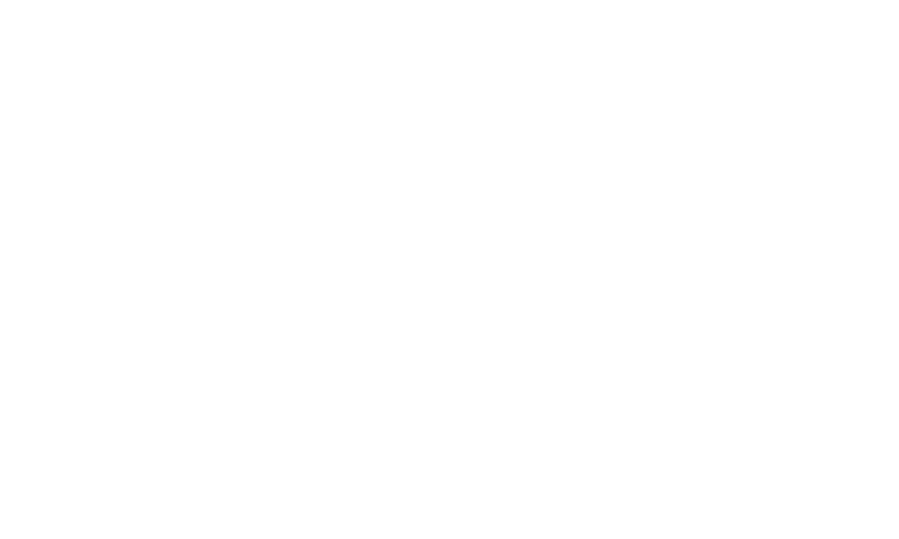

<IPython.core.display.Javascript object>


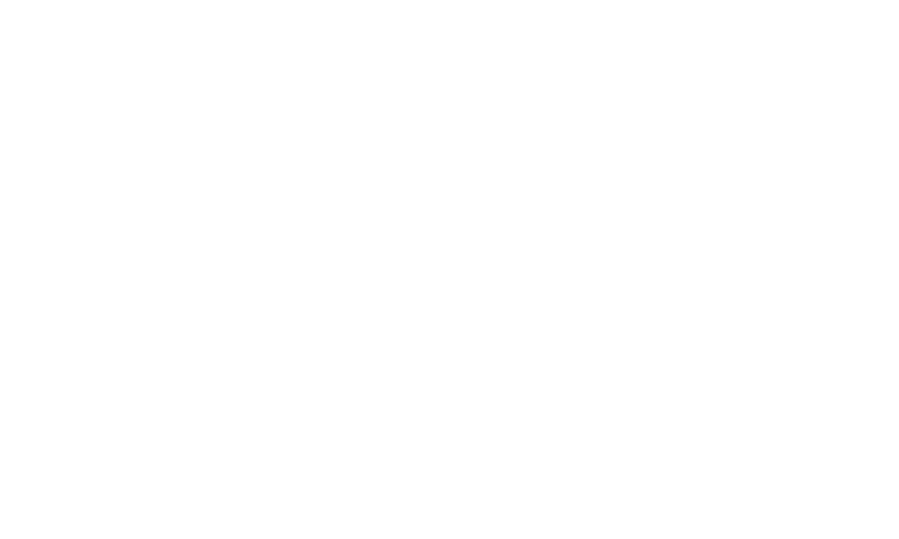

<IPython.core.display.Javascript object>


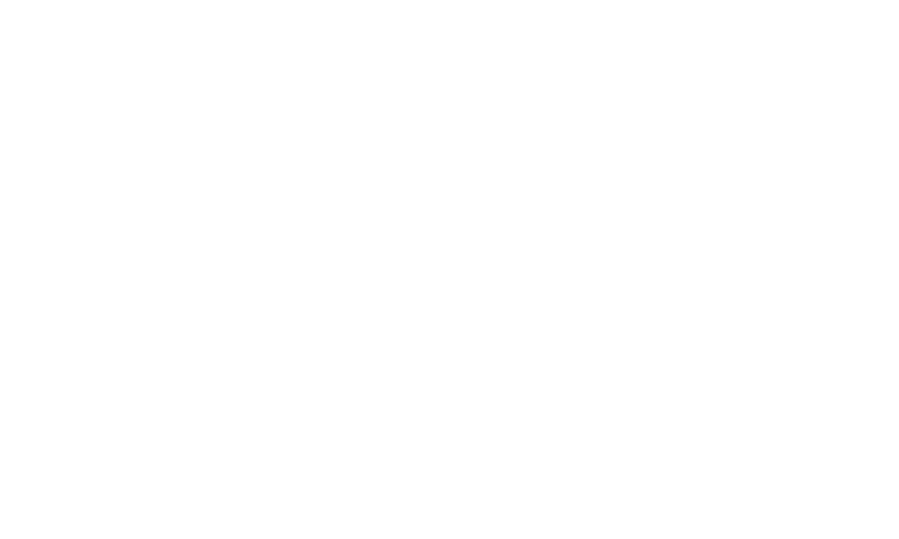

<IPython.core.display.Javascript object>


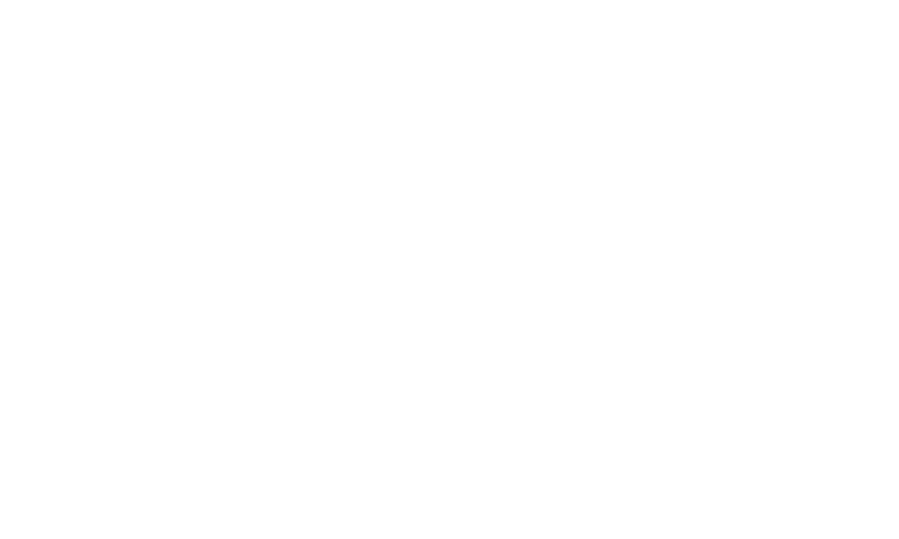

<IPython.core.display.Javascript object>


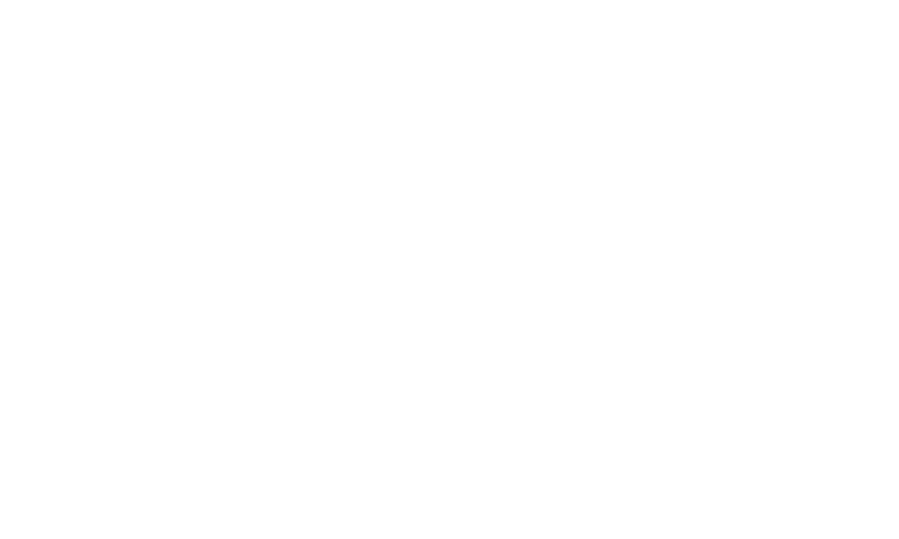

<IPython.core.display.Javascript object>


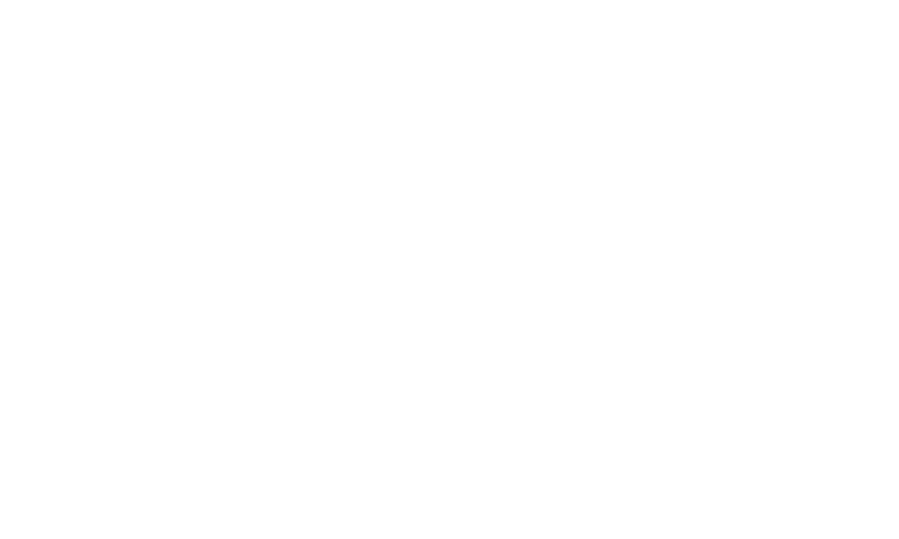

<IPython.core.display.Javascript object>


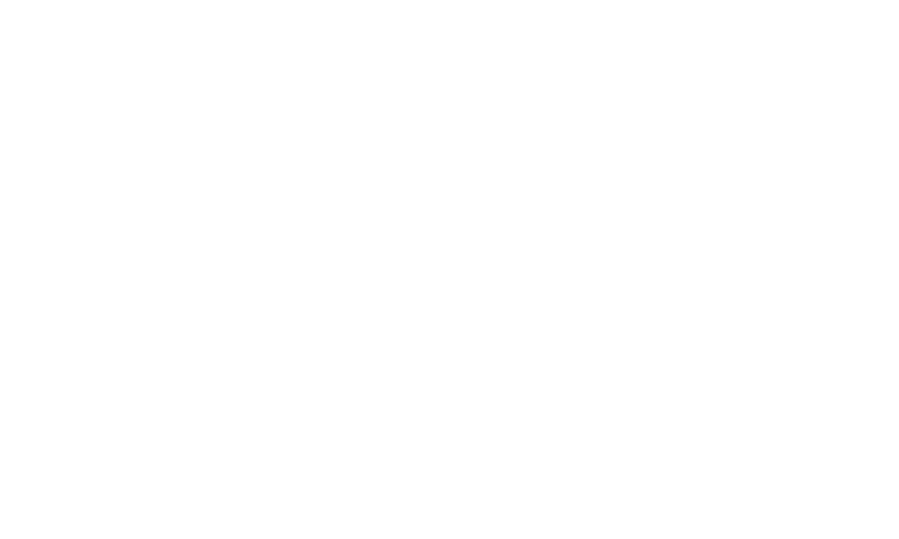

<IPython.core.display.Javascript object>


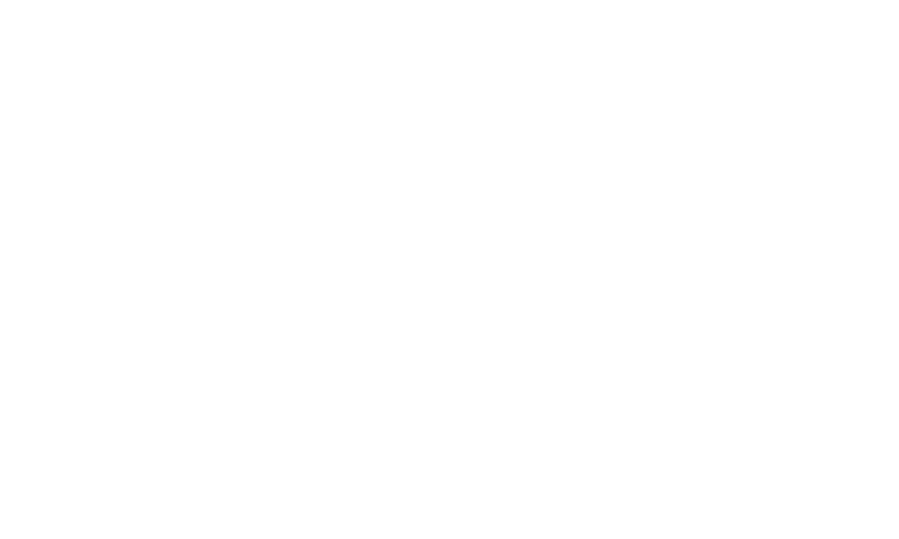

<IPython.core.display.Javascript object>


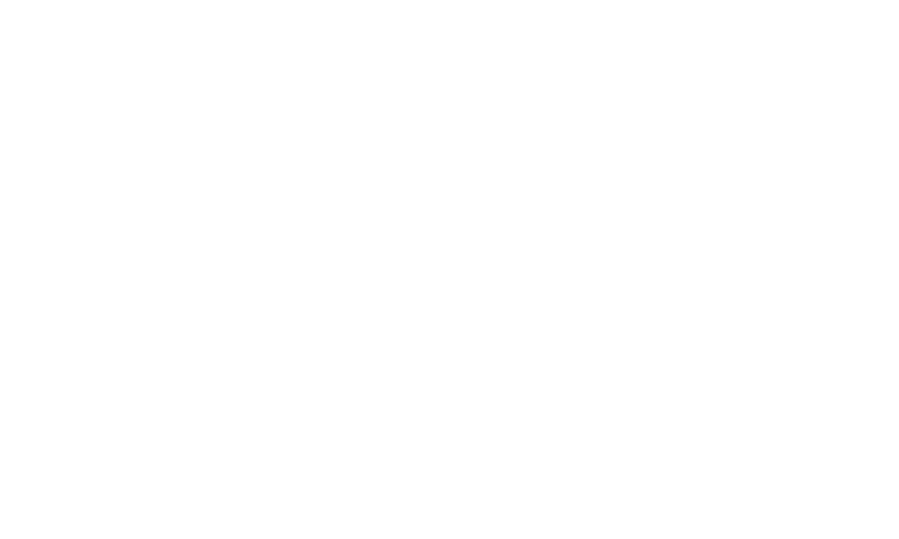

<IPython.core.display.Javascript object>


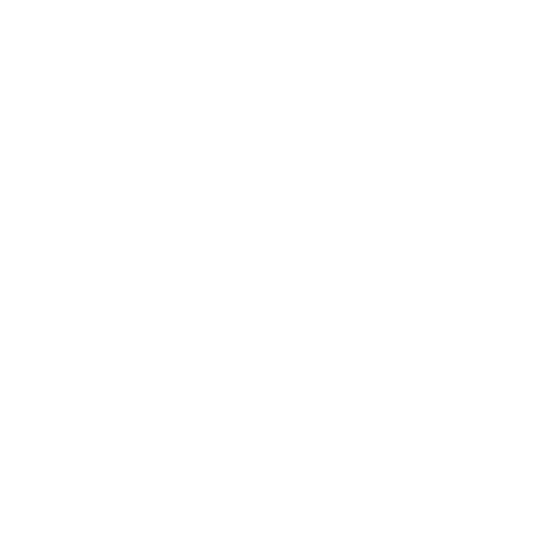

<IPython.core.display.Javascript object>


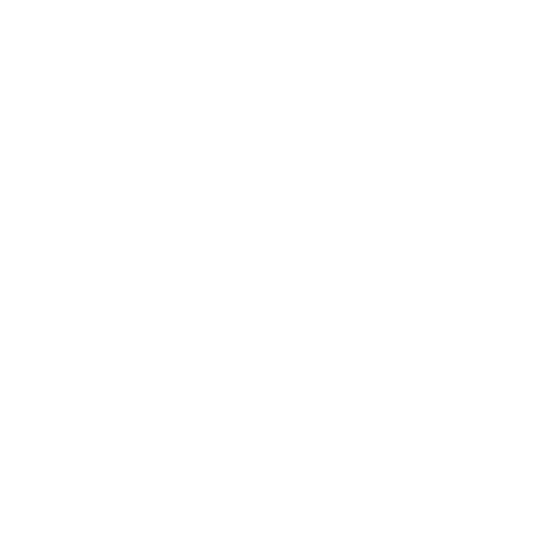

<IPython.core.display.Javascript object>


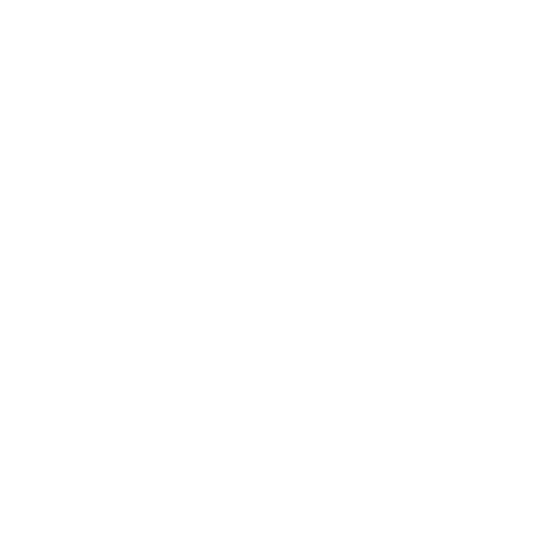

<IPython.core.display.Javascript object>


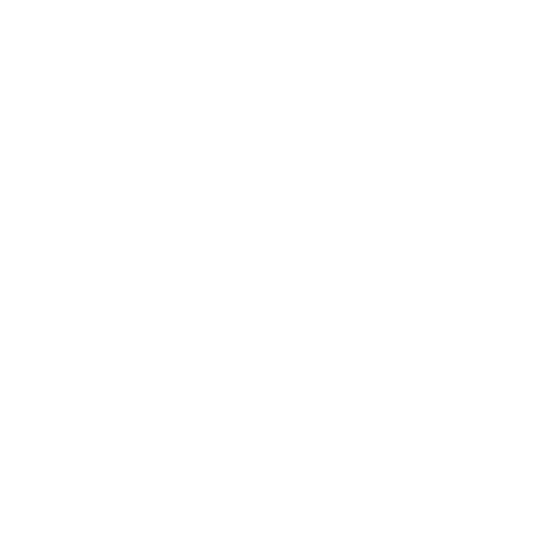

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [46]:
K2TranPix('/Users/ryanr/Documents/PhD/coding/Kepler/Data/ktwo201834023-c01_lpd-targ.fits.gz',save)

In [27]:
test = np.load('/Users/ryanr/Documents/PhD/coding/Kepler/K2/c01/Limit/201834023_Limit.npz')

In [34]:
test2 = test['arr_0']

In [36]:
test2.shape

(14, 15)

<IPython.core.display.Javascript object>


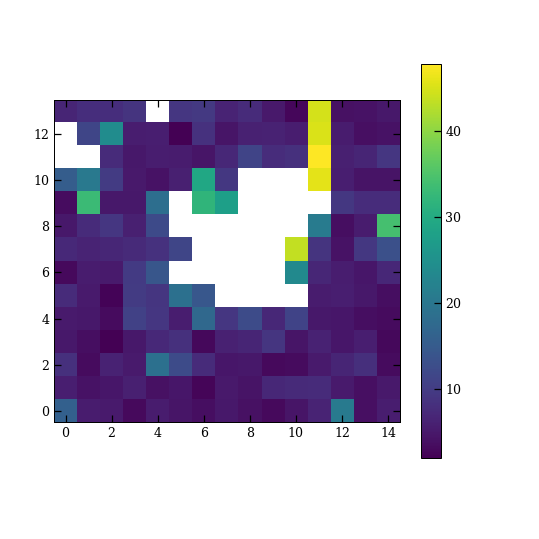

In [41]:
plt.figure()
plt.imshow(test2,origin = 'lower')
plt.colorbar()

In [38]:
Rez = []
rez = []
for filename in tqdm_notebook(Files):
    rez = K2tranPix(filename,save)
    Rez.append(rez)
    rez = []
np.save(save+'c6_Results.npy',Rez)

HBox(children=(IntProgress(value=0, max=47560), HTML(value='')))

KeyboardInterrupt: 

In [33]:
i

NameError: name 'i' is not defined

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from scipy.signal import convolve2d
from scipy.signal import deconvolve
from scipy.ndimage.filters import convolve

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from glob import glob
import os

from tqdm import tnrange, tqdm_notebook
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from scipy.ndimage.filters import convolve

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from glob import glob
import os

from tqdm import tnrange, tqdm_notebook
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

def MinThrustframe(data,thrust):
    mean = np.nanmean(data[thrust+1],axis = 0)
    std = np.nanstd((data[thrust+1] - mean), axis = (1,2))
    Framemin = np.where(std == np.nanmin(abs(std)))[0][0]
    return thrust[Framemin]+1

def DriftKiller(data,thrust):
    # The right value choice here is a bit ambiguous, though it seems that typical variations are <10.
    Drift = (abs(data[thrust+1]-data[thrust-1]) < 10)*1.0 
    Drift[Drift == 0] = np.nan
    j = 0
    for i in range(len(thrust)):
        data[j:thrust[i]] = data[j:thrust[i]]*Drift[i]
        j = thrust[i]
    return data

def FindMinFrame(data):
    # Finding the reference frame
    n_steps = 12
    std_vec = np.zeros(n_steps)
    for i in range(n_steps):
        std_vec[i] = np.nanstd(data[i:-n_steps+i:n_steps,:,:] - data[i+n_steps*80,:,:])
    Framemin = np.where(std_vec==np.nanmin(std_vec))[0][0]
    return Framemin

def ObjectMask(datacube,Framemin):
    # Make a mask of the target object, using the reference frame 
    Mask = datacube[Framemin,:,:]/(np.nanmedian(datacube[Framemin,:,:])+np.nanstd(datacube[Framemin,:,:]))
    Mask[Mask>=1] = np.nan
    Mask[Mask<1] = 1
    # Generate a second mask from remainder of the first. This grabs the fainter pixels around known sources
    Maskv2 = datacube[Framemin,:,:]*Mask/(np.nanmedian(datacube[Framemin,:,:]*Mask)+np.nanstd(datacube[Framemin,:,:]*Mask))
    Maskv2[Maskv2>=1] = np.nan
    Maskv2[Maskv2<1] = 1
    return Maskv2

def ThrustObjectMask(data,thrust):
    StartMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        Start = data[thrust[:3]+1]*StartMask/(np.nanmedian(data[thrust[:3]+1]*StartMask, axis = (1,2))+np.nanstd(data[thrust[:3]+1]*StartMask, axis = (1,2)))[:,None,None]
        Start = Start >= 1
        temp = (np.nansum(Start*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        StartMask = StartMask*temp


    EndMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        End = data[thrust[-3:]+1]*EndMask/(np.nanmedian(data[thrust[-3:]+1]*EndMask, axis = (1,2))+np.nanstd(data[thrust[-3:]+1]*EndMask, axis = (1,2)))[:,None,None]
        End = End >= 1
        temp = (np.nansum(End*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        EndMask = EndMask*temp
    
        
    Mask = np.nansum([np.ma.masked_invalid(StartMask).mask,np.ma.masked_invalid(EndMask).mask],axis=(0))*1.0
    Mask[Mask!=2] = 1
    Mask[Mask==2] = np.nan
    return Mask



def EventSplitter(events,Times,Masks,framemask):
    Events = []
    times = []
    mask = []
    for i in range(len(events)):
        # Check if there are multiple transients
        Coincident = Masks[events[i]]*framemask[events[i]]*1
        positions = np.where(Coincident == 1)
        if len(positions[0]) >1:
            for p in range(len(positions[0])):
                eventmask = np.zeros((Masks.shape[1],Masks.shape[2]))
                eventmask[positions[0][p],positions[1][p]] = 1
                eventmask = convolve(eventmask,np.ones((3,3)),mode='constant', cval=0.0)
                Similar = np.where((Masks[Times[i][0]:,:,:]*eventmask == eventmask).all(axis=(1,2)))[0]
                
                if len((np.diff(Similar)<5)) > 1:
                    
                    if len(np.where((np.diff(Similar)<5) == False)[0]) > 0:
                        SimEnd = np.where((np.diff(Similar)<5) == False)[0][0] 
                    else:
                        SimEnd = -1
                else:
                    SimEnd = 0
                #if len(np.where((np.diff(Similar)<5) == False)[0]) < 1:
                #    SimEnd = -1
                #else:
                #    SimEnd = np.where((np.diff(Similar)<5) == False)[0][0] - 1
                Similar = Similar[:SimEnd]
                if len(Similar) > 1:
                    timerange = [Similar[0]+Times[i][0]-1,Similar[-1]+Times[i][0]+1]
                    if len(timerange) > 1:
                        Events.append(events[i])
                        times.append(timerange)
                        mask.append(eventmask)
                
        else:
            Events.append(events[i])
            times.append(Times[i])
            mask.append(Masks[events[i]])
            

    return Events, times, mask

def Asteroid_fitter(Mask,Time,Data, plot = False):
    lc = np.nansum(Data*Mask,axis=(1,2))
    middle = np.where(np.nanmax(lc[Time[0]-1:Time[-1]+1]) == lc)[0][0]
    x = np.arange(middle-2,middle+2+1,1)
    x2 = np.arange(0,len(x),1)
    y = lc[[np.arange(middle-2,middle+2+1,1)]]
    p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)
    p2 = np.poly1d(p1)
    AvLeft = np.nansum(abs(lc[Time[0]:Time[-1]] - p2(np.arange(Time[0],Time[-1]))))/(Time[-1]-Time[0])
    maxpoly = np.where(np.nanmax(p2(x)) == p2(x))[0][0]
    if (AvLeft < 100) &  (abs(middle - x[maxpoly]) < 2):
        asteroid = True
        if plot == True:
            p2 = np.poly1d(p1)
            plt.figure()
            plt.plot(x,lc[x],'.')
            plt.plot(x,p2(x),'.')
            plt.ylabel('Counts')
            plt.xlabel('Time')
            plt.title('Residual = ' + str(residual))
            
    else:
        asteroid = False

        
    return asteroid 

def Smoothmax(interval,Lightcurve,qual):
    x = np.arange(interval[0],interval[1],1.)
    x[qual[interval[0]:interval[-1]]!=0] = np.nan 
    nbins = int(len(x)/5)
    y = np.copy(Lightcurve[interval[0]:interval[-1]])
    y[qual[interval[0]:interval[-1]]!=0] = np.nan
    
    if np.nansum(x) > 0:
        n, _ = np.histogram(x, bins=nbins,range=(np.nanmin(x),np.nanmax(x)))
        sy, _ = np.histogram(x, bins=nbins, weights=y,range=(np.nanmin(x),np.nanmax(x)))
        sy2, _ = np.histogram(x, bins=nbins, weights=y*y,range=(np.nanmin(x),np.nanmax(x)))
        mean = sy / n
        std = np.sqrt(sy2/n - mean*mean)

        xrange = np.linspace(np.nanmin(x),np.nanmax(x),len(x))
        y_smooth = np.interp(xrange, (_[1:] + _[:-1])/2, mean)
        y_smooh_error = np.interp(xrange, (_[1:] + _[:-1])/2, std)

        temp = np.copy(y)
        temp[y_smooh_error>10] =np.nan

        maxpos = np.where(temp == np.nanmax(temp))[0]+interval[0]
    else:
        maxpos = 0
    return maxpos

def ThrusterElim(Events,Times,Masks,Firings,Quality,qual,Data):
    temp = []
    temp2 = []
    temp3 = []
    asteroid = []
    asttime = []
    astmask = []
    for i in range(len(Events)):
        Range = Times[i][-1] - Times[i][0]
        if (Range > 0) & (Range/Data.shape[0] < 0.8) & (Times[i][0] > 5): 
            begining = Firings[(Firings >= Times[i][0]-3) & (Firings <= Times[i][0]+1)]
            if len(begining) == 0:
                begining = Quality[(Quality >= Times[i][0]-3) & (Quality <= Times[i][0]+1)]
            end = Firings[(Firings >= Times[i][-1]-1) & (Firings <= Times[i][-1]+3)]
            if len(end) == 0:
                end = Quality[(Quality >= Times[i][-1]-1) & (Quality <= Times[i][-1]+3)]
            eventthrust = Firings[(Firings >= Times[i][0]) & (Firings <= Times[i][-1])]
            
            if (~begining.any() & ~end.any()) & (len(eventthrust) < 3):
                
                if Asteroid_fitter(Masks[i],Times[i],Data):
                    asteroid.append(Events[i])
                    asttime.append(Times[i])
                    astmask.append(Masks[i])
                else:
                    temp.append(Events[i])
                    temp2.append(Times[i])
                    temp3.append(Masks[i])
            elif len(eventthrust) >= 3:
                if begining.shape[0] == 0:
                    begining = 0
                else:
                    begining = begining[0]   
                if end.shape[0] == 0:
                    end = Times[i][-1] + 10
                else:
                    end = end[0]
                LC = np.nansum(Data*Masks[i], axis = (1,2))
                maxloc = Smoothmax(Times[i],LC,qual)

                if ((maxloc > begining) & (maxloc < end)): 
                    postmean = np.nanmedian(LC[eventthrust[(qual[eventthrust+1]==0)]+1])
                    Outsidethrust = Firings[(Firings < Times[i][0]) | (Firings > Times[i][-1]+20)]
                    Outsidemean = np.nanmedian(LC[(Outsidethrust[(qual[Outsidethrust+1]==0)]+1)])
                    Outsidestd = np.nanstd(LC[(Outsidethrust[(qual[Outsidethrust+1]==0)]+1)])
                    if  postmean > Outsidemean+Outsidestd:
                        temp.append(Events[i])
                        temp2.append(Times[i])
                        temp3.append(Masks[i])

    events = np.array(temp)
    eventtime = np.array(temp2)
    eventmask = np.array(temp3)
    return events, eventtime, eventmask, asteroid, asttime, astmask


def pix2coord(x,y,mywcs):
    wx, wy = mywcs.wcs_pix2world(x, y, 0)
    return np.array([float(wx), float(wy)])

def Get_gal_lat(mywcs,datacube):
    ra, dec = mywcs.wcs_pix2world(int(datacube.shape[1]/2), int(datacube.shape[2]/2), 0)
    b = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs').galactic.b.degree
    return b




def K2tranPix(pixelfile,save): # More efficient in checking frames
    try:
        hdu = fits.open(pixelfile)
        dat = hdu[1].data
        datacube = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data#np.copy(testdata)#
        if datacube.shape[1] > 1 and datacube.shape[2] > 1:
            #print('in')
            time = dat["TIME"] + 2454833.0
            Qual = hdu[1].data.field('QUALITY')
            thrusters = np.where((Qual == 1048576) | (Qual == 1089568) | (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | (Qual == 10240) | (Qual == 32768) )[0]
            quality = np.where(Qual != 0)[0]
            #calculate the reference frame
            Framemin = FindMinFrame(datacube)
            # Apply object mask to data
            Mask = ThrustObjectMask(datacube,thrusters)

            Maskdata = datacube*Mask
            #Maskdata[Maskdata<0] = 0 

            #Motion control
            #Conv = convolve2d(np.ma.masked_invalid(Mask).mask, np.ones((3,3)), mode="same")
            #Maskdata = Maskdata*(Conv < 2)

            # Make a mask for the object to use as a test to eliminate very bad pointings
            obj = np.ma.masked_invalid(Mask).mask
            objmed = np.nanmedian(datacube[thrusters+1]*obj,axis=(0))
            objstd = np.nanstd(datacube[thrusters+1]*obj,axis=(0))
            Maskdata[(np.nansum(datacube*obj,axis=(1,2)) < np.nansum(objmed-3*objstd)),:,:] = np.nan

            #overflow = ((convolve(Maskdata[(np.nansum(datacube*obj,axis=(1,2)) > np.nansum(objmed+2*objstd)),:,:],
                                  #np.ones((1,1,2)), mode='constant', cval=0.0)) >= 1)*1.0
            #overflow[overflow == 1] = np.nan
            #overflow[overflow == 0] = 1
            #Maskdata[(np.nansum(datacube*obj,axis=(1,2)) > np.nansum(objmed+2*objstd)),:,:] = overflow
            #Maskdata[Maskdata > 170000] = np.nan
            #Stdframe = np.ones(Maskdata.shape)
            framemask = np.zeros(Maskdata.shape)

            #Index = (np.nansum(datacube*obj,axis=(1,2))>np.nansum(objmed-3*objstd)) #((np.nanstd(Maskdata,axis=(1,2)) > np.nanmedian(stddist)) & ((Maskdata.shape[1]>1) & (Maskdata.shape[2]>1))) 
            #framemask[Index] = (Maskdata[Index]/(np.nanmedian(Maskdata[Index])+2*(np.nanstd(Maskdata[Index])))) >= 1
            framemask = ((Maskdata/abs(np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))) >= 1)
            framemask[:,np.where(Maskdata > 170000)[1],np.where(Maskdata > 170000)[2]] = 0
            #Index = ((np.nanstd(Maskdata) > np.nanmedian(stddist)+np.nanstd(stddist)) & ((Maskdata.shape[1]==1) | (Maskdata.shape[2] == 1))) 

            # Identify if there is a sequence of consecutive or near consecutive frames that meet condtition 
            #Eventmask = (convolve(framemask,np.ones((5,3,3)),mode='constant', cval=0.0) >= 3)


            Eventmask = (convolve(framemask,np.ones((1,3,3)),mode='constant', cval=0.0))*1
            Eventmask[~np.where((convolve(Eventmask,np.ones((5,1,1)),mode='constant', cval=0.0) >= 4))[0]] = 0
            Eventmask[Qual!=0,:,:] = False
            #print(np.where(np.nansum(Real_position*Eventmask,axis=(1,2))>0)[0])

            #Eventmask = DriftKiller(Eventmask*Maskdata,thrusters) > 0
            #Eventmask[np.isnan(Eventmask)] = 0
            Index = np.where(np.nansum(Eventmask*1, axis = (1,2))>0)[0]
            events = []
            eventtime = []
            while len(Index) > 1:
                #print('1')
                similar = Index[((Eventmask[Index[0]]*Eventmask[Index]) == Eventmask[Index[0]]).all(axis = (1,2))]
                
                #similar = similar[np.append(True, np.diff(similar)<5)]
                if len((np.diff(similar)<5)) > 1:
                    #print('2')
                    
                    if len(np.where((np.diff(similar)<5) == False)[0]) > 0:
                        simEnd = np.where((np.diff(similar)<5) == False)[0][0] 
                    else:
                        simEnd = -1
                else:
                    simEnd = 0

                if simEnd > 0:
                    similar = similar[:simEnd]
                else:
                    similar = np.array([similar[0]])

                if len(similar) > 1:
                    events.append(similar[0])
                    temp = [similar[0]-1,similar[-1]+1]
                    eventtime.append(temp)
                    temp = []
                for number in similar:
                    if ((Eventmask[Index[0]]*Eventmask[number]) == Eventmask[number]).all():
                        Index = np.delete(Index, np.where(Index == number)[0])

            events, eventtime, eventmask = EventSplitter(events,eventtime,Eventmask,framemask)     
            #eventtime = np.array(eventtime)
            events = np.array(events)
            eventmask = np.array(eventmask)



            # Eliminate events that begin/end within 2 cadences of a thruster fire

            events, eventtime, eventmask, asteroid, asttime, astmask = ThrusterElim(events,eventtime,eventmask,thrusters,quality,Qual,Maskdata)
            events = np.array(events)
            eventtime = np.array(eventtime)
            eventmask = np.array(eventmask)


            temp = []
            temp2 = []
            temp3 = []
            for i in range(len(eventtime)):
                if len(eventtime[i])>0:
                    t = np.nansum(Eventmask[eventtime[i][0]:eventtime[i][-1],:,:]*1,axis=(1,2)) > 0
                    if np.sum(t)/t.shape[0] > 0.6:
                        temp.append(eventtime[i][:])
                        temp2.append(events[i])
                        temp3.append(eventmask[i])
            eventtime = np.array(temp)
            events = np.array(temp2)
            eventmask = np.array(temp3)


            temp = []
            for i in range(len(events)):
                if len(np.where(datacube[eventtime[i,0]:eventtime[i,-1]]*eventmask[i] > 170000)[0]) == 0:
                    temp.append(i)
            eventtime = eventtime[temp]
            events = events[temp]
            eventmask = eventmask[temp]
            
            # Save asteroids
            ast = {}
            ast['File'] = pixelfile
            ast['Asteroids'] = asteroid
            ast['Time'] = asttime
            ast['Mask'] = astmask

            astsave = '/Users/ryanr/Documents/PhD/coding/Kepler/K2/' + pixelfile.split('-')[1].split('_')[0] + '/Asteroid/' + pixelfile.split('ktwo')[-1].split('-')[0]+'_Asteroid.npy'
            np.save(astsave,ast)
            
            
            # Create an array that saves the total area of mask and time. 
            # 1st col pixelfile, 2nd duration, 3rd col area, 4th col number of events, 5th 0 if in galaxy, 1 if outside
            Result = np.zeros(5)
            # Define the coordinate system 
            funny_keywords = {'1CTYP4': 'CTYPE1',
                              '2CTYP4': 'CTYPE2',
                              '1CRPX4': 'CRPIX1',
                              '2CRPX4': 'CRPIX2',
                              '1CRVL4': 'CRVAL1',
                              '2CRVL4': 'CRVAL2',
                              '1CUNI4': 'CUNIT1',
                              '2CUNI4': 'CUNIT2',
                              '1CDLT4': 'CDELT1',
                              '2CDLT4': 'CDELT2',
                              '11PC4': 'PC1_1',
                              '12PC4': 'PC1_2',
                              '21PC4': 'PC2_1',
                              '22PC4': 'PC2_2'}
            mywcs = {}
            for oldkey, newkey in funny_keywords.items():
                mywcs[newkey] = hdu[1].header[oldkey] 
            mywcs = WCS(mywcs)

            # Check if in the galaxy plane -20 < b < 20
            b = Get_gal_lat(mywcs,datacube)
            if (float(b) > -20) and (float(b) < 20):
                Result[4] = 0 
            else:
                Result[4] = 1
            # Check through each of the identified frame sets to see if there is anything and save a figure if so

            counter = 0
            for i in range(len(events)):
                # Check if there are multiple transients
                #Find Coords of transient
                position = np.where(eventmask[i])
                middle = int(np.ceil(np.nansum(eventmask[i])/2))
                Coord = pix2coord(position[0][middle],position[1][middle],mywcs)

                # Generate a light curve from the transient masks
                LC = np.nansum(Maskdata*eventmask[i], axis = (1,2))
                BG = Maskdata*~Eventmask[events[i]]
                BG[BG <= 0] =np.nan
                BGLC = np.nanmedian(BG, axis = (1,2))

                maxcolor = np.nanmax(Maskdata[eventtime[i][0]:eventtime[i][-1]]*eventmask[i])

                fig = plt.figure(figsize=(10,6))
                # set up subplot grid
                gridspec.GridSpec(3,3)

                # large subplot
                plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
                plt.title('Masked light curve (BJD '+str(round(time[eventtime[i][0]]-time[0],2))+', RA '+str(round(Coord[0],3))+', DEC '+str(round(Coord[1],3))+')')
                plt.xlabel('Time (+'+str(time[0])+' BJD)')
                plt.ylabel('Flux')
                plt.plot(time - time[0], LC,'.', label = 'Event LC')
                plt.plot(time - time[0], BGLC,'k.', label = 'Background LC')
                plt.axvspan(time[eventtime[i][0]]-time[0]-.5/24,time[eventtime[i][-1]]-time[0]+.5/24, color = 'orange', label = 'Event duration')
                plt.axvline(time[quality[0]]-time[0],color = 'red', linestyle='dashed',label = 'Quality', alpha = 0.5)
                for j in range(quality.shape[0]-1):
                    j = j+1 
                    plt.axvline(time[quality[j]]-time[0], linestyle='dashed', color = 'red', alpha = 0.5)
                # plot Thurster firings 
                plt.axvline(time[thrusters[0]]-time[0],color = 'red',label = 'Thruster', alpha = 0.5)
                for j in range(thrusters.shape[0]-1):
                    j = j+1 
                    plt.axvline(time[thrusters[j]]-time[0],color = 'red', alpha = 0.5)
                xmin = time[eventtime[i][0]]-time[0]-(eventtime[i][-1]-eventtime[i][0])/10
                xmax = time[eventtime[i][-1]]-time[0]+(eventtime[i][-1]-eventtime[i][0])/10
                if xmin < 0:
                    xmin = 0
                if xmax > time[-1] - time[0]:
                    xmax = time[-1] - time[0]
                plt.xlim(xmin,xmax) # originally 48 for some reason
                plt.ylim(0,np.nanmax(LC[eventtime[i][0]:eventtime[i][-1]])+0.1*np.nanmax(LC[eventtime[i][0]:eventtime[i][-1]]))
                plt.legend(loc = 1)
                # small subplot 1 Reference image plot
                plt.subplot2grid((3,3), (0,2))
                plt.title('Reference')
                plt.imshow(Maskdata[Framemin,:,:], origin='lower',vmin=0,vmax = maxcolor)
                plt.colorbar()
                # small subplot 2 Event mask
                plt.subplot2grid((3,3), (1,2))
                plt.title('Mask')
                plt.imshow(eventmask[i], origin='lower')
                plt.colorbar()
                # small subplot 3 Image of event
                plt.subplot2grid((3,3), (2,2))
                plt.title('Event')
                plt.imshow(Maskdata[np.where(Maskdata*eventmask[i]==np.nanmax(Maskdata[eventtime[i][0]:eventtime[i][-1]]*eventmask[i]))[0][0],:,:], origin='lower',vmin=0,vmax = maxcolor)
                plt.colorbar()
                if eventmask.shape[0] == 1 or eventmask.shape[1] == 1:
                    plt.xticks([-0.5,0,0.5],['',0,''])
                # fit subplots and save fig
                fig.tight_layout()
                #fig.set_size_inches(w=11,h=7)
                plt.savefig(save+pixelfile.split('/')[-1].split('-')[0]+'_'+str(counter)+'.pdf', bbox_inches = 'tight');
                Result[3] += 1
                counter += 1


            Result[0] = int(pixelfile.split('ktwo')[-1].split('-')[0])
            Result[1] = (time[-1] - time[0]) - 3*len(thrusters)/48 # Last term is for removing coincident times
            Result[2] = np.nansum(Mask*1)
        else:
            Result = np.ones(5)*np.nan
    except (OSError):
        Result = np.ones(5)*-1
    return Result

In [33]:

# coding: utf-8

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from scipy.signal import convolve2d
from scipy.signal import deconvolve
from scipy.ndimage.filters import convolve

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from glob import glob
import os

from tqdm import tnrange, tqdm_notebook
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from scipy.ndimage.filters import convolve

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from glob import glob
import os

from tqdm import tnrange, tqdm_notebook
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

def MinThrustframe(data,thrust):
    mean = np.nanmean(data[thrust+1],axis = 0)
    std = np.nanstd((data[thrust+1] - mean), axis = (1,2))
    Framemin = np.where(std == np.nanmin(abs(std)))[0][0]
    return thrust[Framemin]+1

def DriftKiller(data,thrust):
    # The right value choice here is a bit ambiguous, though it seems that typical variations are <10.
    Drift = (abs(data[thrust+1]-data[thrust-1]) < 10)*1.0 
    Drift[Drift == 0] = np.nan
    j = 0
    for i in range(len(thrust)):
        data[j:thrust[i]] = data[j:thrust[i]]*Drift[i]
        j = thrust[i]
    return data

def FindMinFrame(data):
    # Finding the reference frame
    n_steps = 12
    std_vec = np.zeros(n_steps)
    for i in range(n_steps):
        std_vec[i] = np.nanstd(data[i:-n_steps+i:n_steps,:,:] - data[i+n_steps*80,:,:])
    Framemin = np.where(std_vec==np.nanmin(std_vec))[0][0]
    return Framemin

def ObjectMask(datacube,Framemin):
    # Make a mask of the target object, using the reference frame 
    Mask = datacube[Framemin,:,:]/(np.nanmedian(datacube[Framemin,:,:])+np.nanstd(datacube[Framemin,:,:]))
    Mask[Mask>=1] = np.nan
    Mask[Mask<1] = 1
    # Generate a second mask from remainder of the first. This grabs the fainter pixels around known sources
    Maskv2 = datacube[Framemin,:,:]*Mask/(np.nanmedian(datacube[Framemin,:,:]*Mask)+np.nanstd(datacube[Framemin,:,:]*Mask))
    Maskv2[Maskv2>=1] = np.nan
    Maskv2[Maskv2<1] = 1
    return Maskv2

def ThrustObjectMask(data,thrust):
    StartMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        Start = data[thrust[:3]+1]*StartMask/(np.nanmedian(data[thrust[:3]+1]*StartMask, axis = (1,2))+np.nanstd(data[thrust[:3]+1]*StartMask, axis = (1,2)))[:,None,None]
        Start = Start >= 1
        temp = (np.nansum(Start*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        StartMask = StartMask*temp


    EndMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        End = data[thrust[-3:]+1]*EndMask/(np.nanmedian(data[thrust[-3:]+1]*EndMask, axis = (1,2))+np.nanstd(data[thrust[-3:]+1]*EndMask, axis = (1,2)))[:,None,None]
        End = End >= 1
        temp = (np.nansum(End*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        EndMask = EndMask*temp
    
        
    Mask = np.nansum([np.ma.masked_invalid(StartMask).mask,np.ma.masked_invalid(EndMask).mask],axis=(0))*1.0
    Mask[Mask!=2] = 1
    Mask[Mask==2] = np.nan
    return Mask



def EventSplitter(events,Times,Masks,framemask):
    Events = []
    times = []
    mask = []
    for i in range(len(events)):
        # Check if there are multiple transients
        Coincident = Masks[events[i]]*framemask[events[i]]*1
        positions = np.where(Coincident == 1)
        if len(positions[0]) >1:
            for p in range(len(positions[0])):
                eventmask = np.zeros((Masks.shape[1],Masks.shape[2]))
                eventmask[positions[0][p],positions[1][p]] = 1
                eventmask = convolve(eventmask,np.ones((3,3)),mode='constant', cval=0.0)
                Similar = np.where((Masks[Times[i][0]:,:,:]*eventmask == eventmask).all(axis=(1,2)))[0]
                
                if len((np.diff(Similar)<5)) > 1:
                    
                    if len(np.where((np.diff(Similar)<5) == False)[0]) > 0:
                        SimEnd = np.where((np.diff(Similar)<5) == False)[0][0] 
                    else:
                        SimEnd = -1
                else:
                    SimEnd = 0
                #if len(np.where((np.diff(Similar)<5) == False)[0]) < 1:
                #    SimEnd = -1
                #else:
                #    SimEnd = np.where((np.diff(Similar)<5) == False)[0][0] - 1
                Similar = Similar[:SimEnd]
                if len(Similar) > 1:
                    timerange = [Similar[0]+Times[i][0]-1,Similar[-1]+Times[i][0]+1]
                    if len(timerange) > 1:
                        Events.append(events[i])
                        times.append(timerange)
                        mask.append(eventmask)
                
        else:
            Events.append(events[i])
            times.append(Times[i])
            mask.append(Masks[events[i]])
            

    return Events, times, mask

def Asteroid_fitter(Mask,Time,Data, plot = False):
    lc = np.nansum(Data*Mask,axis=(1,2))
    middle = np.where(np.nanmax(lc[Time[0]-1:Time[-1]+1]) == lc)[0][0]
    x = np.arange(middle-2,middle+2+1,1)
    x2 = np.arange(0,len(x),1)
    y = lc[[np.arange(middle-2,middle+2+1,1)]]
    p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)
    p2 = np.poly1d(p1)
    AvLeft = np.nansum(abs(lc[Time[0]:Time[-1]] - p2(np.arange(Time[0],Time[-1]))))/(Time[-1]-Time[0])
    maxpoly = np.where(np.nanmax(p2(x)) == p2(x))[0][0]
    if (AvLeft < 100) &  (abs(middle - x[maxpoly]) < 2):
        asteroid = True
        if plot == True:
            p2 = np.poly1d(p1)
            plt.figure()
            plt.plot(x,lc[x],'.')
            plt.plot(x,p2(x),'.')
            plt.ylabel('Counts')
            plt.xlabel('Time')
            plt.title('Residual = ' + str(residual))
            
    else:
        asteroid = False

        
    return asteroid 

def Smoothmax(interval,Lightcurve,qual):
    x = np.arange(interval[0],interval[1],1.)
    x[qual[interval[0]:interval[-1]]!=0] = np.nan 
    nbins = int(len(x)/5)
    y = np.copy(Lightcurve[interval[0]:interval[-1]])
    y[qual[interval[0]:interval[-1]]!=0] = np.nan
    
    if np.nansum(x) > 0:
        n, _ = np.histogram(x, bins=nbins,range=(np.nanmin(x),np.nanmax(x)))
        sy, _ = np.histogram(x, bins=nbins, weights=y,range=(np.nanmin(x),np.nanmax(x)))
        sy2, _ = np.histogram(x, bins=nbins, weights=y*y,range=(np.nanmin(x),np.nanmax(x)))
        mean = sy / n
        std = np.sqrt(sy2/n - mean*mean)

        xrange = np.linspace(np.nanmin(x),np.nanmax(x),len(x))
        y_smooth = np.interp(xrange, (_[1:] + _[:-1])/2, mean)
        y_smooh_error = np.interp(xrange, (_[1:] + _[:-1])/2, std)

        temp = np.copy(y)
        temp[y_smooh_error>10] =np.nan

        maxpos = np.where(temp == np.nanmax(temp))[0]+interval[0]
    else:
        maxpos = 0
    return maxpos

def ThrusterElim(Events,Times,Masks,Firings,Quality,qual,Data):
    temp = []
    temp2 = []
    temp3 = []
    asteroid = []
    asttime = []
    astmask = []
    for i in range(len(Events)):
        Range = Times[i][-1] - Times[i][0]
        if (Range > 0) & (Range/Data.shape[0] < 0.8) & (Times[i][0] > 5): 

            begining = Firings[(Firings >= Times[i][0]-3) & (Firings <= Times[i][0]+1)]
            if len(begining) == 0:
                begining = Quality[(Quality >= Times[i][0]-1) & (Quality <= Times[i][0]+1)]
            end = Firings[(Firings >= Times[i][-1]-1) & (Firings <= Times[i][-1]+3)]
            if len(end) == 0:
                end = Quality[(Quality >= Times[i][-1]-1) & (Quality <= Times[i][-1]+1)]
            eventthrust = Firings[(Firings >= Times[i][0]) & (Firings <= Times[i][-1])]
            
            if (~begining.any() & ~end.any()) & (len(eventthrust) < 3):
                
                if Asteroid_fitter(Masks[i],Times[i],Data):
                    asteroid.append(Events[i])
                    asttime.append(Times[i])
                    astmask.append(Masks[i])
                else:
                    temp.append(Events[i])
                    temp2.append(Times[i])
                    temp3.append(Masks[i])

            elif len(eventthrust) >= 3:

                if begining.shape[0] == 0:
                    begining = 0
                else:
                    begining = begining[0]   
                if end.shape[0] == 0:
                    end = Times[i][-1] + 10
                else:
                    end = end[0]
                LC = np.nansum(Data*Masks[i], axis = (1,2))
                maxloc = Smoothmax(Times[i],LC,qual)

                if ((maxloc > begining) & (maxloc < end)): 
                    postmean = np.nanmedian(LC[eventthrust[(qual[eventthrust+1]==0)]+1])
                    Outsidethrust = Firings[(Firings < Times[i][0]) | (Firings > Times[i][-1]+20)]
                    Outsidemean = np.nanmedian(LC[(Outsidethrust[(qual[Outsidethrust+1]==0)]+1)])
                    Outsidestd = np.nanstd(LC[(Outsidethrust[(qual[Outsidethrust+1]==0)]+1)])

                    if  postmean > Outsidemean+Outsidestd:
                        temp.append(Events[i])
                        temp2.append(Times[i])
                        temp3.append(Masks[i])


    events = np.array(temp)
    eventtime = np.array(temp2)
    eventmask = np.array(temp3)
    #print(events)
    return events, eventtime, eventmask, asteroid, asttime, astmask


def pix2coord(x,y,mywcs):
    wx, wy = mywcs.wcs_pix2world(x, y, 0)
    return np.array([float(wx), float(wy)])

def Get_gal_lat(mywcs,datacube):
    ra, dec = mywcs.wcs_pix2world(int(datacube.shape[1]/2), int(datacube.shape[2]/2), 0)
    b = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs').galactic.b.degree
    return b




def K2tranPix(data, time, Qual, mywcs, Position, Time): 
    try:
        hdu = fits.open(pixelfile)
        dat = hdu[1].data
        datacube = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data
        if datacube.shape[1] > 1 and datacube.shape[2] > 1:
            #print('Run')
            thrusters = np.where((Qual == 1048576) | (Qual == 1089568) | (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | (Qual == 10240) | (Qual == 32768) )[0]
            quality = np.where(Qual != 0)[0]
            #calculate the reference frame
            Framemin = FindMinFrame(datacube)
            # Apply object mask to data
            Mask = ThrustObjectMask(datacube,thrusters)

            Maskdata = datacube*Mask
            #Maskdata[Maskdata<0] = 0 

            #Motion control
            #Conv = convolve2d(np.ma.masked_invalid(Mask).mask, np.ones((3,3)), mode="same")
            #Maskdata = Maskdata*(Conv < 2)

            # Make a mask for the object to use as a test to eliminate very bad pointings
            obj = np.ma.masked_invalid(Mask).mask
            objmed = np.nanmedian(datacube[thrusters+1]*obj,axis=(0))
            objstd = np.nanstd(datacube[thrusters+1]*obj,axis=(0))
            Maskdata[(np.nansum(datacube*obj,axis=(1,2)) < np.nansum(objmed-3*objstd)),:,:] = np.nan

            #overflow = ((convolve(Maskdata[(np.nansum(datacube*obj,axis=(1,2)) > np.nansum(objmed+2*objstd)),:,:],
                                  #np.ones((1,1,2)), mode='constant', cval=0.0)) >= 1)*1.0
            #overflow[overflow == 1] = np.nan
            #overflow[overflow == 0] = 1
            #Maskdata[(np.nansum(datacube*obj,axis=(1,2)) > np.nansum(objmed+2*objstd)),:,:] = overflow
            #Maskdata[Maskdata > 170000] = np.nan
            #Stdframe = np.ones(Maskdata.shape)
            framemask = np.zeros(Maskdata.shape)

            #Index = (np.nansum(datacube*obj,axis=(1,2))>np.nansum(objmed-3*objstd)) #((np.nanstd(Maskdata,axis=(1,2)) > np.nanmedian(stddist)) & ((Maskdata.shape[1]>1) & (Maskdata.shape[2]>1))) 
            #framemask[Index] = (Maskdata[Index]/(np.nanmedian(Maskdata[Index])+2*(np.nanstd(Maskdata[Index])))) >= 1
            framemask = ((Maskdata/abs(np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))) >= 1)
            framemask[:,np.where(Maskdata > 100000)[1],np.where(Maskdata > 100000)[2]] = 0
            #Index = ((np.nanstd(Maskdata) > np.nanmedian(stddist)+np.nanstd(stddist)) & ((Maskdata.shape[1]==1) | (Maskdata.shape[2] == 1))) 

            # Identify if there is a sequence of consecutive or near consecutive frames that meet condtition 
            #Eventmask = (convolve(framemask,np.ones((5,3,3)),mode='constant', cval=0.0) >= 3)
            Real_position = np.zeros((data.shape[1],data.shape[2]))
            Real_position[Position[0],Position[1]] = 1


            Eventmask = (convolve(framemask,np.ones((1,3,3)),mode='constant', cval=0.0))*1
            Eventmask[~np.where((convolve(Eventmask,np.ones((5,1,1)),mode='constant', cval=0.0) >= 4))[0]] = 0
            Eventmask[Qual!=0,:,:] = False
            #print(np.where(np.nansum(Real_position*Eventmask,axis=(1,2))>0)[0])

            #Eventmask = DriftKiller(Eventmask*Maskdata,thrusters) > 0
            #Eventmask[np.isnan(Eventmask)] = 0
            Index = np.where(np.nansum(Eventmask*1, axis = (1,2))>0)[0]
            events = []
            eventtime = []
            while len(Index) > 1:
                #print('1')
                similar = Index[((Eventmask[Index[0]]*Eventmask[Index]) == Eventmask[Index[0]]).all(axis = (1,2))]
                
                #similar = similar[np.append(True, np.diff(similar)<5)]
                if len((np.diff(similar)<5)) > 1:
                    #print('2')
                    
                    if len(np.where((np.diff(similar)<5) == False)[0]) > 0:
                        simEnd = np.where((np.diff(similar)<5) == False)[0][0] 
                    else:
                        simEnd = -1
                else:
                    simEnd = 0

                if simEnd > 0:
                    similar = similar[:simEnd]
                else:
                    similar = np.array([similar[0]])

                if len(similar) > 1:
                    events.append(similar[0])
                    temp = [similar[0],similar[-1]]
                    eventtime.append(temp)
                    temp = []
                for number in similar:
                    if ((Eventmask[Index[0]]*Eventmask[number]) == Eventmask[number]).all():
                        Index = np.delete(Index, np.where(Index == number)[0])
            print(events)
            events, eventtime, eventmask = EventSplitter(events,eventtime,Eventmask,framemask)     
            #eventtime = np.array(eventtime)
            events = np.array(events)
            eventmask = np.array(eventmask)
            if (Real_position*eventmask).any():
                print('2')
                thing = events[np.where(np.nansum(Real_position*eventmask,axis=(1,2))>0)[0]]
                print(thing)
                #print(eventtime[thing])


            # Eliminate events that begin/end within 2 cadences of a thruster fire

            events, eventtime, eventmask, asteroid, asttime, astmask = ThrusterElim(events,eventtime,eventmask,thrusters,quality,Qual,Maskdata)
            events = np.array(events)
            eventtime = np.array(eventtime)
            eventmask = np.array(eventmask)


            temp = []
            temp2 = []
            temp3 = []
            for i in range(len(eventtime)):
                if len(eventtime[i])>0:
                    t = np.nansum(Eventmask[eventtime[i][0]:eventtime[i][-1],:,:]*1,axis=(1,2)) > 0
                    if np.sum(t)/t.shape[0] > 0.6:
                        temp.append(eventtime[i][:])
                        temp2.append(events[i])
                        temp3.append(eventmask[i])

            eventtime = np.array(temp)
            events = np.array(temp2)
            eventmask = np.array(temp3)


            temp = []
            for i in range(len(events)):
                if len(np.where(datacube[eventtime[i,0]:eventtime[i,-1]]*eventmask[i] > 100000)[0]) == 0:
                    temp.append(i)
            eventtime = eventtime[temp]
            events = events[temp]
            eventmask = eventmask[temp]



            Real_position = np.zeros((data.shape[1],data.shape[2]))
            Real_position[Position[0],Position[1]] = 1
            detection = []
            if len(events) > 0:
                Overlap = (((Real_position*eventmask) == 1).any(axis = (1, 2))) & ((time[eventtime[:,0]] - time[Time]) < 4) & (Time < eventtime[:,0])

                detection = events[Overlap]

                false_detection = len(events[~Overlap])
            else:
                false_detection = 0.

            if len(detection) > 0:
                detect = 1.
            else:
                detect = 0.
            if np.nansum(obj*Real_position) > 0:
                Masked = 1.
            else:
                Masked = 0.

        else:
            detect = -1.
            false_detection = -1.
            Masked = -1.
    except (OSError):
        detect = -1.
        false_detection = -1.
        Masked = -1.
    return detect, false_detection, Masked



In [ ]:
thing[0]

In [ ]:
np.nansum(thing[thing[:,4]==1,4])*4

In [ ]:
np.nansum(thing[thing[:,4]==1,4]*thing[thing[:,4]==1,2])*4 # Units arcsec^2days

In [ ]:
np.save('c5Run1.npy',thing)

In [ ]:
thing.shape